# Navigation tutorial

This tutorial showcases the utilities contained in the navigation subpackage of pylanetary. Learn how to use the ModelEllipsoid and Nav classes, how to find a navigation solution for observational data, how to re-project that solution to a rectilinear grid, and how to save a navigation solution to a multi-extension fits file.

In [1]:
# imports
from pylanetary.navigation import *
from pylanetary.utils import Body
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import astropy.units as u

## Basic model of planet disk

Compute latitude, longitude, emission angle values for an ellipsoidal planetary body on a given pixel scale with given north polar angle and sub-observer latitude and longitude using the ModelEllipsoid class.

(87, 87)
One pixel corresponds to approximately 1.4 degrees lat/lon at the sub-observer point


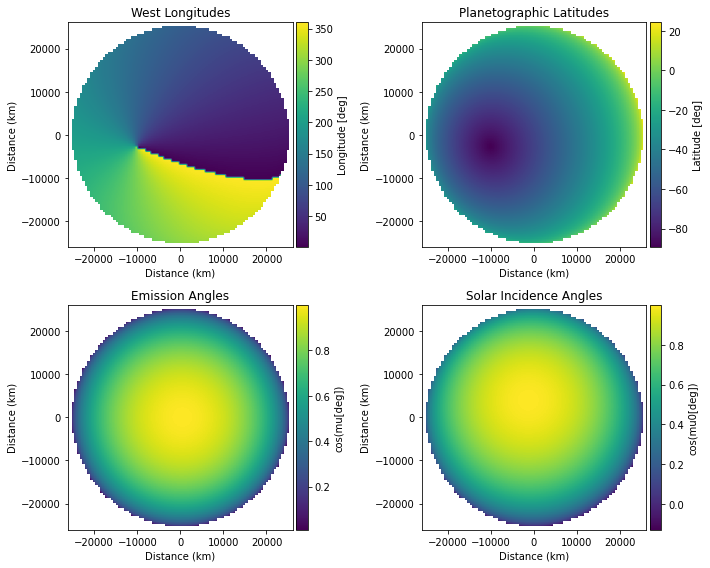

In [2]:
## user-defined inputs
ob_lon = 37.1 #degrees
ob_lat = -65 #degrees
pixscale_km = 600
np_ang = 285 #degrees
req = 25560 #km
rpol = 24970 #km
sun_lon = 60.
sun_lat = 10.

# instantiate a ModelEllipsoid
ellipsoid = ModelEllipsoid(ob_lon, ob_lat, pixscale_km, np_ang, req, rpol, sun_lon=sun_lon, sun_lat=sun_lat)

# its attributes can be called as such
shape = ellipsoid.lon_w.shape
print(shape)
deg_per_px = ellipsoid.deg_per_px
print(f'One pixel corresponds to approximately {deg_per_px:.1f} degrees lat/lon at the sub-observer point')

extent = (-pixscale_km*shape[0]/2, pixscale_km*shape[0]/2, -pixscale_km*shape[1]/2, pixscale_km*shape[1]/2)
fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(2,2, figsize = (10, 8))

im0 = ax0.imshow(ellipsoid.lon_w, origin = 'lower', extent=extent)
ax0.set_title('West Longitudes')
im1 = ax1.imshow(ellipsoid.lat_g, origin = 'lower', extent=extent)
ax1.set_title('Planetographic Latitudes')
im2 = ax2.imshow(ellipsoid.mu, origin = 'lower', extent=extent)
ax2.set_title('Emission Angles')
im3 = ax3.imshow(ellipsoid.mu0, origin = 'lower', extent=extent)
ax3.set_title('Solar Incidence Angles')

ims = [im0, im1, im2, im3]
labels = ['Longitude [deg]', 'Latitude [deg]', 'cos(mu[deg])', 'cos(mu0[deg])']
for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Distance (km)')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(ims[i], cax=cax, orientation='vertical', label=labels[i])

plt.tight_layout()
plt.show()
plt.close()

## Make a beam-convolved limb-darkened disk model

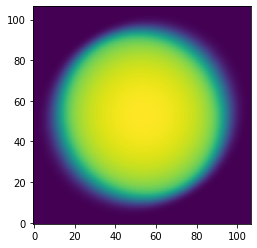

In [3]:
from pylanetary.utils import convolve_with_beam

tb = 99.
a = [0.4, 0.1]
beam = (10., 5., 30.) #FWHM_X, FWHM_Y, THETA_DEG
lddisk = ellipsoid.ldmodel(tb, a, law='quadratic')
lddisk = convolve_with_beam(np.pad(lddisk,10), beam)
plt.imshow(lddisk, origin='lower')
plt.show()

# model corresponding to real data

## instantiate model from Body utility

The Body utility will pull static information about the target, including the equatorial and polar radius, from a .yaml file. It will also query the Horizons ephemeris tool; this information is stored in `ura.ephem` in the example below. See utils tutorial for more details.

In [4]:
from astropy.io import fits

## rewrite with Body util
## should look something like:
hdul = fits.open('data/h_2019oct28.fits') #urh60.fits
pixscale_arcsec = 0.009971 #arcsec, keck

header = hdul[0].header
data = hdul[0].data
obs_time = header['DATE-OBS'] + ' ' + header['EXPSTART'][:-4]
print(obs_time)

# something like this
ura = Body('Uranus', epoch=obs_time, location='568') #Keck
model = ModelBody(ura, pixscale_arcsec)
nav = Nav(data, ura, pixscale_arcsec)

## save ephemeris as astropy Table for testing suite - delete later
#from astropy import io
#io.misc.hdf5.write_table_hdf5(ephem, '/Users/emolter/Python/pylanetary/pylanetary/navigation/tests/data/ephem.hdf5', 
#    serialize_meta=True,
#    overwrite=True)
#np.save('/Users/emolter/Python/pylanetary/pylanetary/navigation/tests/data/keck_uranus.npy', data)

FileNotFoundError: [Errno 2] No such file or directory: 'data/h_2019oct28.fits'

Note: if you want to change anything about the ephemeris data, you would do something like this:
```
ura = Body('Uranus', epoch=obs_time, location='568') #Keck
ura.ephem['NPole_ang'] = 0.0
model = ModelBody(ura, pixscale_arcsec)
```

## Make limb-darkened disk model, then center and shift

In [ ]:
# try centering using convolution with limb-darkened disk
flux = 2000 # surface brightness in whatever units are in the fits file
a = 0.1 # exponential limb-darkening law exponent
fwhm_keck = 0.5 # approximate FWHM of the point-spread function in arcsec
ldmodel = nav.ldmodel(flux, a, beam=fwhm_keck, law='exp')

## save ldmodel as numpy file for testing suite - delete later
#np.save('/Users/emolter/Python/pylanetary/pylanetary/navigation/tests/data/ldmodel.npy', ldmodel)

# center the lat, lon, and mu grids. 
# note it is not necessary to make the ldmodel separately (as shown above) in order to run centering
# err should be the RMS noise of the image
rms_noise = np.std(data[600:900,50:250]) * 10 #for some reason, error returns zero if true RMS is used
# wonder if this should truly be per-pixel error, or per-beam error
dx, dy, dxerr, dyerr = nav.colocate(mode='disk', tb = flux, a = a, beam = fwhm_keck, err=rms_noise)
print('suggested x,y shift is ', dx, dy)
print('x,y uncertainty is ', dxerr, dyerr)

# we could also use an edge-detection algorithm. this is useful if 
# the planet disk is faint and the clouds are bright, e.g., for Neptune in K-band
dx_canny, dy_canny, _, _ = nav.colocate(mode='canny', tb = flux, a = a, beam = fwhm_keck, low_thresh=1e-5, high_thresh=0.01, sigma=5)
print('Canny x,y shift is', dx_canny, dy_canny)

nav.xy_shift_model(dx, dy)
## note: alternatively, we could center the data
# nav.xy_shift_data(-dx, -dy)


#extent = (-pixscale_km*shape[0]/2, pixscale_km*shape[0]/2, -pixscale_km*shape[1]/2, pixscale_km*shape[1]/2)
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (15, 6))

im0 = ax0.imshow(nav.lon_w, origin = 'lower')
ax0.set_title('West Longitudes')
im1 = ax1.imshow(nav.lat_g, origin = 'lower')
ax1.set_title('Planetographic Latitudes')
im2 = ax2.imshow(nav.mu, origin = 'lower')
ax2.set_title('Emission Angles')

ax0.set_ylabel('Distance (pix)')
ax1.set_yticks([])
ax2.set_yticks([])

for ax in [ax0, ax1, ax2]:
    ax.set_xlabel('Distance (pix)')
    ax.set_aspect('equal')

plt.show()

## save one of these as np array for testing suite - delete later
#np.save('/Users/emolter/Python/pylanetary/pylanetary/navigation/tests/data/lat_g_keck.npy', nav.lat_g)

## summary of method for Souami et al 2023, in prep

The centroid of the stacked Keck frames was found by cross-correlating the images with a limb-darkened disk model of Neptune. The model disk was assumed ellipsoidal, with equatorial and polar radii of 24764 km and 24341 km, respectively \footnote{\url{https://nssdc.gsfc.nasa.gov/planetary/factsheet/neptunefact.html}}. The model was scaled to the distance and orientation of Neptune as viewed from Keck Observatory using the JPL Horizons system, accessed using the Astropy-affiliated \texttt{astroquery} Python package. The limb darkening was applied using a Minnaert law with coefficient k = 0.867 \footnote{Wong et al 2018 value in HST blue filter; LMK if anyone finds a better value for the IR somewhere https://doi.org/10.3847/1538-3881/aaa6d6}. The model was convolved with a Gaussian beam to simulate the optics of the telescope. The FWHM of this beam was estimated based on the point-spread function of point sources in the field-of-view (e.g., Proteus). The surface brightness of the limb-darkened disk was set to be the approximate surface brightness of Neptune in cloud-free regions. Image registration between model and data was then carried out using a matrix-multiply discrete Fourier transform technique, implemented using the \texttt{chi2_shift} function within the Astropy-affiliated \texttt{image_registration} Python package \footnote{https://github.com/keflavich/image_registration}. Given the RMS noise in the image as input, this technique also yields errors in the shifts using a delta-chi-square criterion.  The values of the FWHM, model brightness, and limb-darkening parameter were varied within reasonable ranges, and the resulting x,y position was found not to change by more than 1 sigma in either direction.

## reproject data onto lat-lon grid

In [ ]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
projected, mu_projected = nav.reproject()

extent = (0, 360, -90, 90)
fig, (ax0, ax1) = plt.subplots(2,1, figsize = (8,8))

im0 = ax0.imshow(projected, origin = 'lower', extent=extent, vmin=0, vmax = 3500)
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("right", size="7%", pad="2%")
cb0 = fig.colorbar(im0, cax=cax0, label='Counts')

im1 = ax1.imshow(mu_projected, origin = 'lower', extent=extent)
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cb1 = fig.colorbar(im1, cax=cax1, label='Emission Angle')

ax0.set_ylabel('Planetographic Latitude')
ax1.set_ylabel('Planetographic Latitude')
ax1.set_xlabel('West Longitude')
ax0.set_xticks([])

plt.show()

## save these as np array for testing suite - delete later
#np.save('/Users/emolter/Python/pylanetary/pylanetary/navigation/tests/data/projected.npy', projected)
#np.save('/Users/emolter/Python/pylanetary/pylanetary/navigation/tests/data/mu_projected.npy', mu_projected)

This works well! For planets with banded structure, it is easy to check the quality of the co-location based on whether or not the bands appear straight in these images. If the centroid is shifted, then the bands are curved! 

Note here that by default, reproject() will keep the same pixel scale as the original data at the sub-observer point. This means that at every other location, the projected image is oversampled as compared with the original data. This oversampling of the original pixel grid can cause unusual-looking artifacts near the limbs of the planet. To change this default behavior, simply use: reproject(pixscale_arcsec=float)

## save outputs as fits

Internal save functions are not yet implemented